# Multi-Stream Contactor Tutorial (Solution)

The purpose of this tutorial is to introduce the IDAES Multi-stream Contactor model and to demonstrate its application to a membrane filtration process. The IDAES Multi-stream Contactor model is a simple, general purpose model which can be used as a building block for modeling any process which involves multiple separate or immiscible streams with material, energy and/or momentum transfer between the streams.

The Multi-Stream Contactor model provides a building blocks which creates the set of material, energy and momentum balances necessary to model the unit operation along with the necessary State Blocks to describe the material properties at each point in space and time set of Pyomo variables that describe the inter-stream transfer terms. Users can then add any necessary constraints required to define these transfer terms in the form they desire; in this way users can avoid the effort of having to write and test the balance equations themselves and can focus instead on what makes their process unique.

This tutorial will take users through the following:

* Creating and using a simple property package with only volumetric flowrate and mass concentrations as properties.
* Configuring and using the IDAES Multi-Stream Contactor model.
* Adding additional variables and constraints to IDAES models.
* Building and initializing a flowsheet with multiple recycles and mixing streams.
* Adding flowsheet level Expressions for product recovery.
* Changing design variables to match published results.

## Case Study: Separation of Lithium from Cobalt via Diafiltration

For this tutorial, we will use a membrane diafiltration process to separate lithium ions from cobalt ions sourced from recycling Lithium-ion batteries. In a diafiltration process, membranes are used to selectively separate different components in the feed stream, and a dilute diafiltrate stream is added to the process in order to avoid solubility-limits. The specific case study is drawn from Figure 2, Case III in the following paper:

Wamble, N.P., Eugene, E.A., Phillip, W.A., Dowling, A.W., 'Optimal Diafiltration Membrane Cascades Enable Green Recycling of Spent Lithium-Ion Batteries', ACS Sustainable Chem. Eng. 2022, 10, 12207−12225

![diafiltration_pfd.png](./diafiltration_pfd.png)

In this process, we have three membrane stages where each stage is further divided into 10 membrane elements (representing individual membrane cartridges). The feed and recycle streams for this process were determined by solving a superstructure problem, resulting in the interest case where the fresh feed is fed to the last element of the final membrane stage, followed by a non-intuitive series of recycles and introduction of the diafiltrate stream.

As this example comes from a superstructure example, the model only considers mass balances and the mass transfer across the membrane is specified using a constant water flux and sieving coefficients for lithium and cobalt ions.

The following steps will take you through the process of building and solving the flowsheet for this case study using IDAES and Pyomo tools.
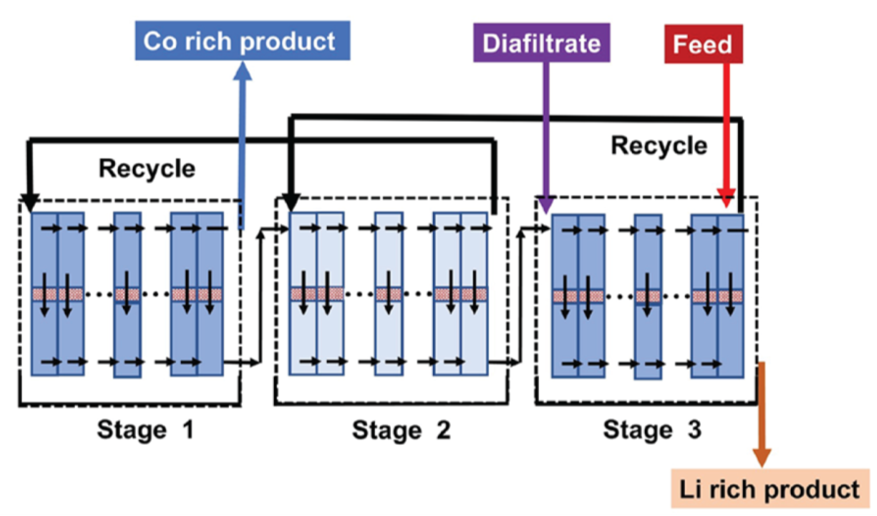

## Step 1: Import Components

The first thing we need to do is import the various components we will be using from Pyomo and IDAES. For now, we will just import most of these and explain their purpose when we come to use them.

In [1]:
import pyomo.environ as pyo
from pyomo.network import Arc

from idaes.core import (
    Component,
    declare_process_block_class,
    FlowsheetBlock,
    MaterialBalanceType,
    MaterialFlowBasis,
    Phase,
    PhysicalParameterBlock,
    StateBlock,
    StateBlockData,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.initialization import fix_state_vars

## Step 2: Property Package

The next thing we need to do is to define a "property package" for our process. In order to support modularity and re-usability of models, IDAES separates the thermophysical and reaction properties into separate "packages" so that they can be easily swapped in and out of models as desired. Whilst this does add some additional overhead when first building a model, it saves a lot of time later when you need to apply the same model to a different application as all you need to do is write a new property package for the new application (rather than rebuild the entire unit model or flowsheet). For more complex models, it also makes it easy to test the property calculations in isolation from the unit model when trying to debug model failures.

One key feature of IDAES is flexibility - as much as possible the standards which define a type of model in IDAES are intentionally kept as minimal as possible. For property packages, this means that IDAES does not specify what properties need to be defined by a package; rather unit models will assume that the properties they require are defined and try to access these and raise an Exception if they cannot find them. This means that when writing a property package you only need to include those properties that you expect to use for your process.

As mentioned previously, in this case study we will only be considering material balances and that the material transfer terms will be defined by relatively simple sieving coefficients. This means that we will only need a few properties in order to model this system and thus the property package we need to define will be fairly short. The properties we will need are:

* three chemical species (water, lithium ions, and cobalt ions) and one phase (liquid),
* total volumetric flow of material (IDAES includes extensive flow information in the property packages to support full modularization of the property definitions),
* concentration of lithium and cobalt ions (we will assume that the ion concentration is relatively low and that the concentration of water is equal to its pure component density), and,
* the density of pure water (assumed constant).

### Structure of a Property Package

Property packages in IDAES consist of three distinct components:

* A Parameter Block, which represents a centralized component for the properties which gets attached to the overall flowsheet. This component serves to define the property package in the flowsheet and a central location for storing global parameters related to properties that are constant across the entire flowsheet (such as the constant density of water for this example).
* A State Block Data class which contains the actual property variables and constraints and will be used in every unit model to represent the material state at each point in space and time.
* A State Block class which works alongside the State Block Data class and is used to define utility methods that can be applied to multiple State Block Data instances at one time. The most common examples of these methods are initialization routines that can be applied to all points in space and time simultaneously (so that we don’t need to initialize each point individually).

The following sections will take you through the process of defining a simple property package for this example.

### State Block Class

Due to the nature of Python (and programming in general), any object must be defined before you go to use. For property packages, this unfortunately means we need to define these classes in reverse order, and starting with the State Block class, then the State Block Data and finally the Parameter Block as the later classes contain references to early ones in order to allow us to automate things later.

Thus, the first thing we need to do is define the State Block class and the associated common methods associated with initialization. Due to the simplicity of this example, these methods are mostly placeholders (so that we don't get AttributeErrors when the unit model initialization methods try to call property initialization methods).

For this, we need to define a class (which we will call ``_StateBlock``) which inherits from the IDAES ``StateBlock`` base class and then define two class methods:

* ``fix_initialization_states``: this method is used during initialization to make the associated State Block Data instances square (zero degrees of freedom) so that they can be initialized and solved in isolation. For this example, all we need to do is fix the state variables (we will define what these are in the State Block Data class) for each State Block Data instance for which IDAES has a convenient helper function called ``fix_state_vars``. For more complex models there may need to be addition steps here to activate or deactivate constraints for initialization.
* ``initialization_routine``: this method is whee we would define a custom initialization routine for our State Block Data instances. For this example, we don’t actually have any calculations to initialize in our model as it will just include the state variables, so all we need to do is include a ``pass`` statement here.

The code to define the ``_StateBlock`` class is shown below.

In [2]:
class _StateBlock(StateBlock):
    def fix_initialization_states(self):
        """
        Fixes state variables for state blocks.

        Returns:
            None
        """
        fix_state_vars(self)

    def initialization_routine(self):
        pass

Next we define the State Block Data class, which we will call ``LiCoStateBlockData`` which will inherit from the IDAES ``StateBlockData`` base class. The first thing we need to do when declaring this class is to use the ``declare_process_block_class`` decorator with ``"LiCoStateBlock`` as a positional argument and our ``_StateBlock`` class as the ``block_class`` argument (see below). For now, it is sufficient to k ow that this decorator creates a new meta-class named ``LiCoStateBlock`` (for the positional argument) that replicates the internal Pyomo ``Block`` class structure (combining the ``_StateBlock`` class with the class we are in the process of declaring.

Next, our new State Block Data class needs to define a number of methods that will be used by other parts of the framework to automatically assemble unit models.

* ``build`` method: this method is called automatically whenever an instance of the State Block is created and is used to populate the resulting ``Block`` with the necessary variables and constraints to describe the properties at a single point in space and time (the resulting ``Block`` will carry the time and space indices so all our variables and constraints do not need to worry about this). For this example, all we need to do is add the state variables we are going to use to represent the state of the material, which are the total volumetric flowrate (``flow_vol``) and the mass concentration of the ionic species (``conc_mass_solute``). Note that there are standard names that we are expected to use for these quantities which can be found in the IDAES documentation.
* ``get_material_flow_terms`` method: this method is used by unit models to determine what expression they should use in their material balance equations to represent material flow terms. As IDAES does not specify a specific set of state variables to use in a property package, this is how the unit model knows what to put in the balance equation. This method takes two arguments, which are a specific phase and component to return the flow term for (the names of phases and components will be defined in the Parameter Block). In this case, we have two different cases for the flow term;

  * If we want the flow of the solvent species then we need to multiply the total volumetric flowrate by the density of water, which will be defined in the associated Parameter Block. Fortunately, the ``StateBlockData`` base class includes some infrastructure to create a pointer to the Parameter Block class for us so we can access this parameter via the ``self.params`` property (see below for example).
  * For the ionic species, we instead want to multiply the total volumetric flowrate by the mass concentration of the appropriate species.
  
* ``get_material_flow_basis`` method: this method is used to inform unit models of the basis used for the material flow terms, as there are a number of different bases that we may want to use depending on how we want to write our property calculations and unit models. In this case, we are using mass balances so we set this to return ``MaterialFlowBasis.mass`` (the ``MaterialFlowBasis`` Enum is defined in IDAES to list the different forms currently supported by the IDAES framework).
* ``define_state_vars`` method: this is where we define the variables which constitute the "state variables " for our property package (and thus get fixed by the ``fix_initialization_states`` method in the ``_StateBlock`` class, as well as defining what information gets passed between unit models at the flowsheet level). This method needs to return a ``dict`` of the state variable objects where the key is a string name (by convention the name of the variable as a string) and the key is the variable object). In this case, our two state variables are ``flow_vol`` and ``conc_mass_solute``).

The full code to define the new State Block Data class is shown below.

In [3]:
@declare_process_block_class("LiCoStateBlock", block_class=_StateBlock)
class LiCoStateBlock1Data(StateBlockData):
    def build(self):
        super().build()

        self.flow_vol = pyo.Var(
            units=pyo.units.m**3 / pyo.units.hour,
            bounds=(1e-8, None),
        )
        self.conc_mass_solute = pyo.Var(
            ["Li", "Co"],
            units=pyo.units.kg / pyo.units.m**3,
            bounds=(1e-8, None),
        )

    def get_material_flow_terms(self, p, j):
        if j == "solvent":
            # Assume constant density of pure water
            return self.flow_vol * self.params.dens_H2O
        else:
            return self.flow_vol * self.conc_mass_solute[j]

    def get_material_flow_basis(self):
        return MaterialFlowBasis.mass

    def define_state_vars(self):
        return {
            "flow_vol": self.flow_vol,
            "conc_mass_solute": self.conc_mass_solute,
        }

### Parameter Block Class

The step in crating the property package is to define a class for the Parameter Block which we will call ``LiCoParameterData`` and inherit from the ``PhysicalParameterBlock`` base class. Once again, we need to use the ``declare_process_block_class`` decorator, although this time we do not need to provide a ``block_class`` argument as we do not have any methods to declared that should be shared across multiple instances of the parameter block (in fact, we generally expect there will only be a single instance).

The Physical Parameter Block needs to define two methods:

* ``build`` method: much like the State Block Data class we need to define a ``build`` method that will be called when ever we create an instance for the Parameter Block. In this case, we need to define any global components or parameters that will make up our property package, for which we have four things to declare:

  * The phases of interest in our system. In this case we have a single phase which we will just call ``phase1``. To define a phase we simply create an instance of an IDAES ``Phase`` component. Here we will use the generic ``Phase`` component, however there are specialized components for different types of phase (such as a ``Liquid`` component). Each ``Phase`` we define is automatically added to a ``phase_list`` ``Set`` for us.
  * The chemical components of interest in the system. For this example we have three components of interest which are the ``solvent`` and the two ionic species, ``Li`` and ``Co``. To define these, we create instances of the IDAES ``Component`` component for each (there are also specialized ``Component`` types as well). As for ``Phases``, each ``Component`` we define is automatically added to a ``component_list`` set for us.
  * A Pyomo ``Param`` component to define the constant density of water we are assuming for the system. We will set this with a default value of 1000 and also define the units of measurement for this value (kg/m^3).
  * Finally, we also define a pointer to the ``LiCoStateBlock`` metaclass that was created in the previous step. This pointer is used to let us build instances of the State Block Data class directly from the Parameter Block instance (so that we don't have to remember which class we are meant to be using. This is especially important for larger flowsheets with multiple property packages).

* ``define_metadata`` classmethod: this method is used to define some metadata for the property package. This metadata is used by unit models to determine things like the system of units being used by the property package so that the unit model can automatically adapt and do unit conversions if required. In order to ensure unit consistency, IDAES allows users to define a base unit for the seven main SI quantities (time, length, mass, amount, temperature, and optionally current and luminous intensity) and then uses these to derive the units of measurement for all other quantities.

The code below shows how to define the Parameter Block for this example.

In [4]:
@declare_process_block_class("LiCoParameters")
class LiCoParameterData(PhysicalParameterBlock):
    def build(self):
        super().build()

        self.phase1 = Phase()

        self.solvent = Component()
        self.Li = Component()
        self.Co = Component()

        self.dens_H2O = pyo.Param(
            default=1000,
            units=pyo.units.kg / pyo.units.m**3,
        )

        self._state_block_class = LiCoStateBlock

    @classmethod
    def define_metadata(cls, obj):
        obj.add_default_units(
            {
                "time": pyo.units.hour,
                "length": pyo.units.m,
                "mass": pyo.units.kg,
                "amount": pyo.units.mol,
                "temperature": pyo.units.K,
            }
        )

## Step 3: Modelling a Single Stage

Now that we have defined a property package for our system, the next thing to do is start thinking about modeling a membrane stage for this process. We could start writing all the necessary variables and constraints ourselves as a Pyomo model, but one of the big advantages of IDAES is that someone has often already done something similar and has hopefully done a lot of the work for you. In this case, IDAES has the Multi-Stream Contactor model, which already contains all the material balances we need for this model meaning we can start with it and only need to add the additional constraints we need to define the mass transfer of each species across the membrane.

The Multi-Stream Contactor model can be imported as shown below, and documentation can be [found here](https://idaes-pse.readthedocs.io/en/latest/reference_guides/model_libraries/generic/unit_models/mscontactor.html)

In [5]:
from idaes.models.unit_models import MSContactor, MSContactorInitializer

If you take a look at the documentation for the ``MSContactor`` class, you might notice that it a very general model has a lot of options and that it includes support for things that we do not need for this example (such as energy and momentum balances). Many IDAES models (such as this one) support configuration arguments which allow users to turn different features on and off in order to customize them for their specific application. Configuration arguments can be set on a unit-by-unit basis by providing these arguments whenever an instance of the model is added to a flowsheet. Note however that these arguments are only used during construction, and that once the model has been constructed they cannot be changed.

We will look at the options for the ``MSContactor`` model a bit more later when we go to add instances of these to our flowsheet.

### Step 3a: Build the Flowsheet

Now that we have all the basic model classes we will need, we can start building up the flowsheet to present the case study we are looking at. The first step is to create the ``Flowsheet`Block`` object that will serve as the canvas for constructing the process.

To do this, we first create a Pyomo ``ConcreteModel`` to hold our flowsheet and then add an IDAES ``FlowsheetBlock`` to this. WE also need to decide if the flowsheet will be steady-state or dynamic at this point; for this tutorial we will do a steady-state model so we set ``dynamic=False`` as a configuration argument to the flowsheet.

In [6]:
m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

Next, we need to define the property package we will be using for the flowsheet. To do this, we simply add an instance of the ``LiCoParameters`` we defined in the previous steps to the flowsheet. In this case we did not define any configuration arguments, but some more general property packages support configuration arguments for the parameter block.

In [7]:
m.fs.properties = LiCoParameters()

Next, we will construct a model for the first membrane stage in the process using the ``MSContactor`` class. For this, we need to decide on the configuration arguments to use.

* The process uses 10 membrane elements per stage, so we will set the number of finite elements to 10.
* The process has two streams; the retentate and permeate streams. We set the ``streams`` argument to be a ``dict`` with these names as the keys and the values being another ``dict`` with the configuration options for each stream.

For the retentate side, we are going to set the property package to be ``m.fs.properties`` - the unit model will automatically look up the State Block Data class to use from the Parameter Block for us. Also, we are not interested in energy or momentum balances for this example so we will set these options to ``False`` in the configuration ``dict``.

For the permeate side, the options are similar. However, in this case there is no external feed of material on the permeate side - all flow in the first element is provided by mass transfer across the membrane. The ``MSContactor`` model supports this by setting the ``"has_feed"`` argument to ``False``.

The code required to create a model for the first membrane stage is shown below.

In [8]:
m.fs.stage1 = MSContactor(
    number_of_finite_elements=10,
    streams={
        "retentate": {
            "property_package": m.fs.properties,
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
        "permeate": {
            "property_package": m.fs.properties,
            "has_feed": False,
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
    },
)

The ``MSContactor`` model also supports a number of other configuration options, but we will not look at these at this point.

### Step 3b: Add Mass Transfer Constraints

By adding an instance of the ``MSContactor`` model to our flowsheet, we now have a block that contains all the material balances for the first membrane stage. However, whilst the model includes variables for the mass transfer across the membrane, these are current not defined. Thus, we need to add some additional constraints to define these terms.

From the source paper, the equations used to define the mass transfer terms were:

$ M_{solvent} = \frac{J \times L \times W \times \rho_{solvent}}{N}$

$log(C_{out,j}) + (Sj - 1) \times log(Q_{in}) = log(C_{in,j}) + (Sj - 1) \times log(Q_{out})$

Here:

* $M_j$ represents he mass transfer of species $j$,
* $J = 0.1$ m/hr is the solvent flux across the membrane (constant),
* $L$ and $W = 1.5$ m are the length and width of the membranes in the stage,
* $\rho_{solvent}$ is the density of the solvent, which we can get from the property package,
* $N$ is the number of finite elements in the stage,
* $C_{j}$ is the mass concentration of ionic species $j$ in the retentate side,
* $Q$ is the total volumetric flow of solution on the retentate side, and,
* $S_j$ is a constant sieving coefficient for component $j$.

The first place to start in adding these constraint to the flowsheet is to define variables for the global (flowsheet level) constants $J$, $W$ and $S$. We can add these to the flowsheet as shown below; users should feel free to add new variables and constraint to IDAES models as necessary, but should be careful to avoid name conflicts with existing components.

In [9]:
# Global constants
J = 0.1 * pyo.units.m / pyo.units.hour
w = 1.5 * pyo.units.m

# Add mass transfer variables and constraints
m.fs.solutes = pyo.Set(initialize=["Li", "Co"])

m.fs.sieving_coefficient = pyo.Var(
    m.fs.solutes,
    units=pyo.units.dimensionless,
)
m.fs.sieving_coefficient["Li"].fix(1.3)
m.fs.sieving_coefficient["Co"].fix(0.5)

Next, we need to add the unit level variable $L$ and constraints to our membrane stage, which is shown below. Note that from an overall perspective these could be added to the flowsheet level as well, but it makes more sense to add these to the unit model as they will be important when we try to initialize the model in the next step.

Note that we need to provide and fix a value for the membrane length here so that this is not a degree of freedom in our model later.

In [10]:
m.fs.stage1.length = pyo.Var(units=pyo.units.m)

# Start by initializing with a short length
# Too long and we deplete solvent due to lack of recycles
m.fs.stage1.length.fix(10)


def solvent_rule(b, s):
    return (
        b.material_transfer_term[0, s, "permeate", "retentate", "solvent"]
        == J * b.length * w * m.fs.properties.dens_H2O / 10
    )


m.fs.stage1.solvent_flux = pyo.Constraint(
    m.fs.stage1.elements,
    rule=solvent_rule,
)


def solute_rule(b, s, j):
    if s == 1:
        in_state = b.retentate_inlet_state[0]
    else:
        sp = b.elements.prev(s)
        in_state = b.retentate[0, sp]

    return pyo.log(b.retentate[0, s].conc_mass_solute[j]) + (
        m.fs.sieving_coefficient[j] - 1
    ) * pyo.log(in_state.flow_vol) == pyo.log(in_state.conc_mass_solute[j]) + (
        m.fs.sieving_coefficient[j] - 1
    ) * pyo.log(
        b.retentate[0, s].flow_vol
    )


m.fs.stage1.solute_sieving = pyo.Constraint(
    m.fs.stage1.elements,
    m.fs.solutes,
    rule=solute_rule,
)

### Step 3c: Set Operating Conditions and Initialize Model

At this point, we should have fully defined the equations necessary to model and solve the first membrane stage. In order to test this however, we will need to specify some feed conditions for the stage. If we look back at the process flow diagram, we can see that the feed to the first membrane stage is actually a recycle stream from the retentate outlet of the second stage which we have not modeled yet. So, as an initial guess, let us use the conditions of the fresh feed to the system; looking at the source paper these values are:

* volumetric flowrate of 100 m^3/hr,
* 1.7 kg/m^3 of Lithium ions, and,
* 17 kg/m^3 of Co ions.

The cell below shows how to set the inlet conditions for the first membrane stage. Note that we will be using these feed conditions in a few other locations later so they are defined as constants to make things easier later.

In [11]:
Q = 100
C_Li = 1.7
C_Co = 17

m.fs.stage1.retentate_inlet.flow_vol[0].fix(Q)
m.fs.stage1.retentate_inlet.conc_mass_solute[0, "Li"].fix(C_Li)
m.fs.stage1.retentate_inlet.conc_mass_solute[0, "Co"].fix(C_Co)

At this point, we should have a square model with zero degrees of freedom, but it is always a good idea to check this. We can use the IDAES ``degrees_of_freedom`` function to get the degrees of freedom in our model as shown below.

In [12]:
print(degrees_of_freedom(m.fs.stage1))

0


Now that we have ensured that our model is square, the next step is to initialize the model with some good initial guesses so that we can solve it. Solving equation-oriented models generally requires a good set of initial values in order to be able to solve the model, and trying to find a set of sufficient values is often as much work as constructing the model equations. In order to assist users with this process, IDAES provides a number of ``Initializers`` which can be used to try and find a set of feasible initial values for a model.  IDAES offers a number of different ``Initializers`` which use different approaches to finding the initial set of values which may be better suited to different situations and applications.

For this example, we will make use of the ``MSContactorInitializer``, an ``Initializer`` written specifically to initializer multi-stream contactor models. This initializer uses a simple sequential process to initialize the models states based on the inlet conditions for each stream and should be suitable for this example.

To use the initializer, we first create an instance of it, and then call the ``initializer.initialize`` method providing the model we wish to initialize as an argument. Note that ``Initializers`` are generally specific to a type of model rather than a specific instance, and thus we will be able to use the same instance of this ``Initializer`` later to initializer the other membrane stages. The following code will generate warnings as a result of volumetric flow being set to 0, which is outside of the specified bounds, but these warnings can be ignored.

In [13]:
initializer = MSContactorInitializer()

initializer.initialize(m.fs.stage1)

WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,1].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,2].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,3].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,4].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage1.permeate[0.0,5].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting 

<InitializationStatus.Ok: 1>

### Step 3d: Check Results

All going to plan, we should see that the ``Initializer`` returned ``InitializationStatus.Ok`` to indicate that it was able to successfully initialize and solve the unit for the conditions provided. However, it is always a good idea to take a quick look a the solution to make sure it looks right.

We can check the predicted outlet conditions for the membrane stage by displaying each of the outlets of the model as shown below.

In [14]:
m.fs.stage1.retentate_outlet.display()
m.fs.stage1.permeate_outlet.display()

retentate_outlet : Size=1
    Key  : Name             : Value
    None : conc_mass_solute : {(0.0, 'Co'): 17.128952543235165, (0.0, 'Li'): 1.6923094926234352}
         :         flow_vol : {0.0: 98.5}
permeate_outlet : Size=1
    Key  : Name             : Value
    None : conc_mass_solute : {(0.0, 'Co'): 8.532116327557503, (0.0, 'Li'): 2.205009984394426}
         :         flow_vol : {0.0: 1.5000000000000002}


As we can see, material is being transferred from the retentate to the permeate, and that the transfer is selective to lithium over cobalt (the concentration of lithium in the permeate is higher than in the retentate whilst the concentration of cobalt is lower). This matches what we would expect to see, so we will move on to adding more membrane stages.

## Step 4: Add Second Stage

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Next, let us add a model for the second membrane stage, along with the necessary variables and constraints to describe the mass transfer terms. Use the cell below to add an instance of the MSContactor model named "m.fs.stage2".
    
Hint: You can re-use the methods used to define the rules for the constraints for the first stage.
</div>

In [15]:
# Create an instance of the MSContactor model for the second stage here
m.fs.stage2 = MSContactor(
    number_of_finite_elements=10,
    streams={
        "retentate": {
            "property_package": m.fs.properties,
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
        "permeate": {
            "property_package": m.fs.properties,
            "has_feed": False,
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
    },
)

# Also add the necessary variables and constraints for the material flow terms
# Do not forget to fix any design variables you might need to add
m.fs.stage2.length = pyo.Var(units=pyo.units.m)
m.fs.stage2.length.fix(10)

m.fs.stage2.solvent_flux = pyo.Constraint(
    m.fs.stage2.elements,
    rule=solvent_rule,
)
m.fs.stage2.solute_sieving = pyo.Constraint(
    m.fs.stage2.elements,
    m.fs.solutes,
    rule=solute_rule,
)

For the second membrane stage, the permeate from the first stage is combined with the retentate stream from the third stage. Thus, we need a Mixer model to combine these two streams for which IDAES has a pre-built model we can use. We will import the Mixer model along with a few Enums used to configure how the mixer is constructed as shown below.

In [16]:
from idaes.models.unit_models import (
    Mixer,
    MixingType,
    MomentumMixingType,
    MixerInitializer,
)

We can then add a Mixer with 2 inlets to our flowsheet as shown below.

In [17]:
m.fs.mix1 = Mixer(
    num_inlets=2,
    property_package=m.fs.properties,
    material_balance_type=MaterialBalanceType.componentTotal,
    energy_mixing_type=MixingType.none,
    momentum_mixing_type=MomentumMixingType.none,
)

Next, we need to connect the permeate stream from stage 1 to one of the Mixer inlets, and the Mixer outlet to the second stage feed. We do this using Pyomo Arcs as shown below.

In [18]:
m.fs.stream1 = Arc(
    source=m.fs.stage1.permeate_outlet,
    destination=m.fs.mix1.inlet_2,
)
m.fs.stream2 = Arc(
    source=m.fs.mix1.outlet,
    destination=m.fs.stage2.retentate_inlet,
)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Additionally, the retentate of the second stage is recycled back to be the inlet of the first stage. Add an Arc for this connection below.
</div>

In [19]:
# Add an Arc connecting the retentate of the second stage to the retentate feed of the first stage below.
m.fs.stream3 = Arc(
    source=m.fs.stage2.retentate_outlet,
    destination=m.fs.stage1.retentate_inlet,
)

Whilst this step defines the connectivity between the units, an additional step is required to convert these into actual constraints linking the variables in each unit. To do this, we need to make use of Pyomo's TransformationFactory as shown in the next cell.

In [20]:
pyo.TransformationFactory("network.expand_arcs").apply_to(m)

Now that we have connected the first and second stages together, we need to revisit how we defined the operating conditions. With the feed of the first stage now connected to the outlet of the second stage, we first need to unfix the inlet conditions there.

In [21]:
m.fs.stage1.retentate_inlet.flow_vol[0].unfix()
m.fs.stage1.retentate_inlet.conc_mass_solute[0, "Li"].unfix()
m.fs.stage1.retentate_inlet.conc_mass_solute[0, "Co"].unfix()

In place of that, we instead need to fix the inlet conditions to the unconnected feed in the Mixer. For this, we will use the same feed conditions we used previously for the first stage. 

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Fix the conditions to the mixer (mix1.inlet_1) to that of the fresh feed below. Remember that we created constants for the feed conditions earlier named Q, C_Li and C_Co.
</div>

In [22]:
m.fs.mix1.inlet_1.flow_vol[0].fix(Q)
m.fs.mix1.inlet_1.conc_mass_solute[0, "Li"].fix(C_Li)
m.fs.mix1.inlet_1.conc_mass_solute[0, "Co"].fix(C_Co)

At this point, we should once again have a square models, so we should check the degrees of freedom before continuing. If the result is not 0, then there is something missing that needs to be corrected before continuing.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Use the degrees_of_freedom method to check that the problem is well-defined below.
</div>

In [23]:
print(degrees_of_freedom(m))

0


Assuming everything has worked so far, the next thing we need to do is initialize the new unit models in the flowsheet. The best way to approach this is to work sequentially from known points, making assumptions about any recycle streams we do not know yet (called making a tear stream).

In this case, we have fixed inlet_1 to the mixer and we have already initialized the first stage so we know the condition of the permeate stream which forms the other inlet. Thus, we have good guesses for both inlets of the mixer so we should be able to initialize it now.

The first thing we need to do however is propagate the result from the first stage permeate to the mixer inlet, for which we can use the ``propagate_state`` method from IDAES.

In [24]:
from idaes.core.util.initialization import propagate_state

propagate_state(
    destination=m.fs.mix1.inlet_2,
    source=m.fs.stage1.permeate_outlet,
)

Doing this copies the values of the state variable for the source ``Port`` to the destination ``Port`` for us.

Once that is done, we can set up an Initializer for the Mixer and initialize our unit model. At the beginning of this tutorial we imported an Initializer for mixer units named ``MixerInitializer``, so we can create an instance of this here and then call the ``initialize`` method with our unit model as the argument.

In [25]:
mix_initializer = MixerInitializer()
mix_initializer.initialize(m.fs.mix1)

2023-12-14 13:45:12 [INFO] idaes.init.fs.mix1: Initialization Complete: optimal - Optimal Solution Found


<InitializationStatus.Ok: 1>

Hopefully the ``Initializer`` returned ``InitializationStatus.Ok`` indicating a successful initialization. If it did not, you will need to go back and check that you did everything correctly in previous steps.

Now that the mixer is initialized, we can propagate the state at the mixer outlet to the retentate inlet of our second membrane stage (``m.fs.stage2.retentate_inlet``).

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Use the propagate_state method to copy the conditions from the outlet of m.fs.mix1 to the retentate inlet of m.fs.stage2.
</div>

In [26]:
propagate_state(
    destination=m.fs.stage2.retentate_inlet,
    source=m.fs.mix1.outlet,
)

At this point, we should have good initial guesses for all inlet conditions to the second membrane stage so we should be able to initialize it next. For this, we can re-use the ``Initializer`` we used for the first membrane stage (although you could also create a new ``Initializer`` if you want to do something differently).

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Use the Initializer object we previously created for the first membrane state to initialize m.fs.stage2.
</div>

In [27]:
initializer.initialize(m.fs.stage2)

WARNING (W1002): Setting Var 'fs.stage2.permeate[0.0,1].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage2.permeate[0.0,2].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage2.permeate[0.0,3].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage2.permeate[0.0,4].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage2.permeate[0.0,5].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting 

<InitializationStatus.Ok: 1>

Hopefully we again see ``InitializationStatus.Ok`` indicating that the initialization was completed successfully.


## Step 5: Add Third Stage and Recycle

User Exercise - challenge: account for side feed in third stage

Now that we have the first two stages constructed and initialized, we can move onto the third membrane stage. Looking at the process flow diagram, this stage is slightly different to the first two as we have a side-stream entering the final finite element on the retentate side.

Fortunately, the ``MSContactor`` model already supports this for us via a configuration argument. For each entry in the ``streams`` argument (a ``dict`` if you recall), we can provide a ``"side_streams"`` key which has a ``list`` of finite elements (by number) at which to include a side stream (side streams can be either inlets or outlets depending on whether flow is positive or negative). In this case, we want a single side stream at the 10th finite element on the retentate side, so we need to include ``"side_streams": [10]`` in the retentate ``dict``.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Try constructing the third membrane stage below (call it m.fs.stage3). Remember to include all the necessary values in the streams argument.
</div>

In [28]:
# Add third stage, including side stream feed at element 10

m.fs.stage3 = MSContactor(
    number_of_finite_elements=10,
    streams={
        "retentate": {
            "property_package": m.fs.properties,
            "side_streams": [10],
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
        "permeate": {
            "property_package": m.fs.properties,
            "has_feed": False,
            "has_energy_balance": False,
            "has_pressure_balance": False,
        },
    },
)

If you want to check that you constructed the third stage correctly, the cell below will check for things that should (and should not) be present.

In [29]:
assert isinstance(
    m.fs.stage3, MSContactor
)  # check that stage3 exists and is an MSContactor

# Retentate side checks
assert hasattr(
    m.fs.stage3, "retentate_inlet_state"
)  # check that there is a retentate feed
assert hasattr(
    m.fs.stage3, "retentate_side_stream_state"
)  # check that a side stream exists
for k in m.fs.stage3.retentate_side_stream_state:
    assert k == (0, 10)  # check that the side stream only exists at element 10
assert not hasattr(
    m.fs.stage3, "retentate_energy_balance"
)  # check that there are no energy balances
assert not hasattr(
    m.fs.stage3, "retentate_pressure_balance"
)  # check that there are no pressure balances

# Permeate side checks
assert not hasattr(
    m.fs.stage3, "permeate_inlet_state"
)  # check that there is no permeate feed
assert not hasattr(
    m.fs.stage3, "permeate_side_stream_state"
)  # check that there are no side streams on permeate side
assert not hasattr(
    m.fs.stage3, "permeate_energy_balance"
)  # check that there are no energy balances
assert not hasattr(
    m.fs.stage3, "permeate_pressure_balance"
)  # check that there are no pressure balances

Next, we need to add the variables and constraints needed to define the mass transfer. Due to the retentate side stream, this is a little different to the previous stages as well, as the sieving coefficient is defined based on the total flow entering and leaving an element.

For the solvent, the mass transfer is defined by a constant flux thus the same rule that was used for the first two stages can be applied. However, for the solute species the mass transfer constraint includes the inlet volumetric flowrate and concentration. For the first 9 elements this is the same as for the previous stages, but for the 10th element we need to account for the additional flow from the side stream.

The code below adds the length variable and mass transfer constraints for the third membrane state.

In [30]:
m.fs.stage3.length = pyo.Var(units=pyo.units.m)
m.fs.stage3.length.fix(10)


def stage3_solute_rule(b, s, j):
    if s == 1:
        q_in = b.retentate_inlet_state[0].flow_vol
        c_in = b.retentate_inlet_state[0].conc_mass_solute[j]
    elif s == 10:
        sp = b.elements.prev(s)
        q_in = (
            b.retentate[0, sp].flow_vol + b.retentate_side_stream_state[0, 10].flow_vol
        )
        c_in = (
            b.retentate[0, sp].conc_mass_solute[j] * b.retentate[0, sp].flow_vol
            + b.retentate_side_stream_state[0, 10].conc_mass_solute[j]
            * b.retentate_side_stream_state[0, 10].flow_vol
        ) / q_in
    else:
        sp = b.elements.prev(s)
        q_in = b.retentate[0, sp].flow_vol
        c_in = b.retentate[0, sp].conc_mass_solute[j]

    return pyo.log(b.retentate[0, s].conc_mass_solute[j]) + (
        m.fs.sieving_coefficient[j] - 1
    ) * pyo.log(q_in) == pyo.log(c_in) + (m.fs.sieving_coefficient[j] - 1) * pyo.log(
        b.retentate[0, s].flow_vol
    )


m.fs.stage3.solvent_flux = pyo.Constraint(
    m.fs.stage3.elements,
    rule=solvent_rule,
)
m.fs.stage3.solute_sieving = pyo.Constraint(
    m.fs.stage3.elements,
    m.fs.solutes,
    rule=stage3_solute_rule,
)

Next, we need to add the streams connecting the third stage to the existing stages. From the process flow diagram, we can see the the inlet to the third stage is the result of mixing the fresh diafiltrate stream with the permeate from the second stage.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Add a second mixer (named m.fs.mix2) with 2 inlets to the flowsheet.
</div>

In [31]:
# Add second feed mixer
m.fs.mix2 = Mixer(
    num_inlets=2,
    property_package=m.fs.properties,
    material_balance_type=MaterialBalanceType.componentTotal,
    energy_mixing_type=MixingType.none,
    momentum_mixing_type=MomentumMixingType.none,
)

With the mixer added, we can now define the final three streams which connect the third stage to the flowsheet. The streams we need are:

1. a stream from m.fs.stage2.permeate_outlet to m.fs.mix2.inlet_2,
2. a stream from m.fs.mix2.outlet to m.fs.stage3.retentate_inlet, and,
3. a stream from m.fs.stage3.retentate_outlet to m.fs.mix1.inlet1

We do this by adding three new ``Arcs`` to the flowsheet, and then expanding these as before. Normally you should be careful about applying transformations multiple times, but this is one case where we can repeated apply the same transformation with no negative effects.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Add Arcs to represent the three streams required to connect the second mixer and third stage to the flowsheet. Remember to expand the Arcs when you are done.
</div>

In [32]:
# Add 3 Arcs to connect third stage to remainder of flowsheet
m.fs.stream4 = Arc(
    source=m.fs.stage2.permeate_outlet,
    destination=m.fs.mix2.inlet_2,
)
m.fs.stream5 = Arc(
    source=m.fs.mix2.outlet,
    destination=m.fs.stage3.retentate_inlet,
)
m.fs.stream6 = Arc(
    source=m.fs.stage3.retentate_outlet,
    destination=m.fs.mix1.inlet_1,
)

pyo.TransformationFactory("network.expand_arcs").apply_to(m)

Now that we have all the streams connected, next we need to update the states we are fixing in the flowsheet. Firstly, we had previously fixed the inlet conditions to ``inlet_1`` in the first mixer but we have now added an ``Arc`` which connects that to the outlet of the third stage.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Unfix the volumetric flowrate and concentrations at inlet_1 to the first mixer.
</div>

In [33]:
# Unfix Feed to Mixer 1 inlet 1
m.fs.mix1.inlet_1.flow_vol[0].unfix()
m.fs.mix1.inlet_1.conc_mass_solute[0, "Li"].unfix()
m.fs.mix1.inlet_1.conc_mass_solute[0, "Co"].unfix()

Next, we need to fix the new inlets to the process. This time, we have two inlet states to fix.

1. We need to fix the conditions of the incoming diafiltrate stream (m.fs.mix2.inlet_1). The conditions for this stream from the paper are ``Q=30 m^3/hr``, ``C[Li]=0.1 kg/m^3`` and ``C[Co]=0.2 kg/m^3``
2. We also need to fix the state of the incoming fresh feed at the 10th finite element of the third stage. The ``MSContactor`` model does not define a ``Port`` for this stream so we instead have to go directly to the associated state block in the model. We can find this by going to look at the documentation for the ``MSContactor`` model, and in this case we will find it is named m.fs.stage3.retentate_side_stream_state[0, 10] (Note the indices: the first value (0) is the time index (recall this is a steady-state model) and the second (10) is the finite element we wish to fix). The conditions for this stream are the fresh feed conditions we have used previously.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Fix the states of the incoming feed and diafiltrate streams.
</div>

In [34]:
# Fix Diafiltrate feed to Mixer 2 inlet 1
m.fs.mix2.inlet_1.flow_vol[0].fix(30)
m.fs.mix2.inlet_1.conc_mass_solute[0, "Li"].fix(0.1)
m.fs.mix2.inlet_1.conc_mass_solute[0, "Co"].fix(0.2)

# Fix Feed stream at element 10 of stage 3
m.fs.stage3.retentate_side_stream_state[0, 10].flow_vol.fix(Q)
m.fs.stage3.retentate_side_stream_state[0, 10].conc_mass_solute["Li"].fix(C_Li)
m.fs.stage3.retentate_side_stream_state[0, 10].conc_mass_solute["Co"].fix(C_Co)

Once again, we should check the degrees of freedom to help verify that we have a square model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Check the degrees of freedom for the flowsheet.
</div>

In [35]:
print(degrees_of_freedom(m))

0


Once we have a square model, we are ready to try to finish initializing the flowsheet.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
First, propagate the state from the permeate outlet of stage2 to the second inlet of mix2 and then initialize mix2.
</div>

In [36]:
# Initialize Mixer 2
propagate_state(
    destination=m.fs.mix2.inlet_2,
    source=m.fs.stage2.permeate_outlet,
)

mix_initializer.initialize(m.fs.mix2)

2023-12-14 13:45:12 [INFO] idaes.init.fs.mix2: Initialization Complete: optimal - Optimal Solution Found


<InitializationStatus.Ok: 1>

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Next, try to propagate the state from the outlet of mix2 to the retentate inlet of stage3 and initialize stage3.
Note that this will most likely fail.
</div>

In [37]:
# Try to initialize stage 3
propagate_state(
    destination=m.fs.stage3.retentate_inlet,
    source=m.fs.mix2.outlet,
)

initializer.initialize(m.fs.stage3)

WARNING (W1002): Setting Var 'fs.stage3.permeate[0.0,1].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage3.permeate[0.0,2].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage3.permeate[0.0,3].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage3.permeate[0.0,4].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'fs.stage3.permeate[0.0,5].flow_vol' to a numeric
value `0.0` outside the bounds (1e-08, None).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting 

<InitializationStatus.Ok: 1>

You probably noticed that the above step failed to initialize successfully, and if you look through the traceback you might see a message saying that ``stage3`` converged to an infeasible state. So, what went wrong?

In short, the reason is that we started our initialization in the wrong place and that the inlet conditions to the third stage are infeasible. When we started this tutorial, we began with the first membrane stage, which at first glance might appear to be the logical place to start. However, if we look at the process flow diagram, we can see that all the fresh feed enters at the third stage and that the feed to the other stages is due to recycling of outlets from other stages. In hindsight, it would actually have made more sense to start building and initializing the flowsheet from the third stage instead so that we could start with the well know fresh feed and diafiltrate inlets.

However, for this case at least, we can recover by just initializing the third stage with what would have been our initial guess otherwise. From the process flow diagram we can see the the feed to the third stage consists of the diafiltrate (whose conditions we know) and the outlet of stage 2. Let us assume that the fresh diafiltrate dominates this feed and set the value of the inlet to the third stage to be just the fresh diafiltrate.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Set the value of the flow and concentrations in the retentate inlet of stage 3 to be equal to the fresh diafiltrate and try to initialize the unit again. Note that you should use the set_value() method instead of the fix() method for this.
</div>

In [38]:
# Lets try again
# Initial feed guess is pure diafiltrate (no recycle)
# Remember to only set the value, not fix the inlet
m.fs.stage3.retentate_inlet.flow_vol[0].set_value(30)
m.fs.stage3.retentate_inlet.conc_mass_solute[0, "Li"].set_value(0.1)
m.fs.stage3.retentate_inlet.conc_mass_solute[0, "Co"].set_value(0.2)

initializer.initialize(m.fs.stage3)

2023-12-14 13:45:12 [INFO] idaes.init.fs.stage3: Stream Initialization Completed.
2023-12-14 13:45:12 [INFO] idaes.init.fs.stage3: Initialization Completed, optimal - Optimal Solution Found


<InitializationStatus.Ok: 1>

This time we should see ``InitializationStatus.Ok``

## Step 6: Solve Flowsheet

Now that we have initialized all the unit models, we can attempt to solve the full flowsheet. Whilst we know that the current initial guesses are not correct (after all, we neglected the recycling of the permeate from stage 2 when setting the initial guesses for stage 3), the initial values are feasible and should be sufficiently good that we can solve the full model.

To solve the flowsheet, we can just create a Pyomo ``SolverFactory`` object as usual - in this case we will use IPOPT as the solver. Then, we can apply this to the model and see if it solves.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Create the Pyomo solver object and use it to solve the full model. You might want to set tee=True so that you can see the solver logs.
</div>

In [39]:
solver = pyo.SolverFactory("ipopt")
solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 294, 'Number of variables': 294, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.019769906997680664}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

you should see that IPOPT easily solves the full model in approximately 3 iterations and returns ``Optimal Solution Found``.

Now that we have solved the flowsheet, lets take a look at the lithium rich (``m.fs.stage3.permeate_outlet``) and cobalt rich (``m.fs.stage1.retentate_outlet``) streams using the ``display()`` method.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Use the display() method to check the conditions in the two product streams.
</div>

In [40]:
# Display outlets
m.fs.stage3.permeate_outlet.display()
m.fs.stage1.retentate_outlet.display()

permeate_outlet : Size=1
    Key  : Name             : Value
    None : conc_mass_solute : {(0.0, 'Co'): 0.8883476146511076, (0.0, 'Li'): 0.3828512192732413}
         :         flow_vol : {0.0: 1.5000000000000002}
retentate_outlet : Size=1
    Key  : Name             : Value
    None : conc_mass_solute : {(0.0, 'Co'): 13.26589477492625, (0.0, 'Li'): 1.341834421564904}
         :         flow_vol : {0.0: 128.5}


A quick look at the results shows that we are not actually recovering a lot of lithium in the lithium product, and that most of it is ending up in the cobalt stream instead. The reason for this is because we have set the length of each membrane stage to be a relatively small 100 m as an initial value. The reason we used such a small value was to make sure that we did not push the system to high recoveries during initialization as this generally limits the flexibility of the model. However, now that we have the model fully initialized and solved, we can start pushing the recovery values up by increasing the size of the membranes.

## Step 7: Change Design Conditions

If we were to look at the original paper, we would see that for this case study the original design had a total membrane area of 3404 $m^3$ using isotropic membrane stages (equal length) and achieved a lithium recovery of 95%. With three membrane stages and a fixed membrane width of 1.5 m (we used this earlier in the solvent flux calculations), this gives a length of 756.4 m for each stage.

First, let us add some ``Expressions`` to the flowsheet to calculate the recovery of lithium and cobalt for us. The cell below shows how to add an ``Expression`` for the lithium recovery.

In [41]:
# Add Expressions for recovery
m.Li_recovery = pyo.Expression(
    expr=m.fs.stage3.permeate_outlet.flow_vol[0]
    * m.fs.stage3.permeate_outlet.conc_mass_solute[0, "Li"]
    / (
        m.fs.mix2.inlet_1.flow_vol[0] * m.fs.mix2.inlet_1.conc_mass_solute[0, "Li"]
        + m.fs.stage3.retentate_side_stream_state[0, 10].flow_vol
        * m.fs.stage3.retentate_side_stream_state[0, 10].conc_mass_solute["Li"]
    )
)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Add an Expression for the cobalt recovery.
</div>

In [42]:
m.Co_recovery = pyo.Expression(
    expr=m.fs.stage1.retentate_outlet.flow_vol[0]
    * m.fs.stage1.retentate_outlet.conc_mass_solute[0, "Co"]
    / (
        m.fs.mix2.inlet_1.flow_vol[0] * m.fs.mix2.inlet_1.conc_mass_solute[0, "Co"]
        + m.fs.stage3.retentate_side_stream_state[0, 10].flow_vol
        * m.fs.stage3.retentate_side_stream_state[0, 10].conc_mass_solute["Co"]
    )
)

We can now use the ``display()`` method of these ``Expressions`` to check the current lithium and cobalt recoveries.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Display the values of the lithium and cobalt recovery.
</div>

In [43]:
# Check recovery values
m.Li_recovery.display()
m.Co_recovery.display()

Li_recovery : Size=1
    Key  : Value
    None : 0.0033195192422535375
Co_recovery : Size=1
    Key  : Value
    None : 0.9992189206201778


As we saw from looking at the outlet streams, the lithium recovery is very low (0.3%).

Lets increase the length of the three membrane stages to the 756.4 m from the original paper and see how that improves the recoveries.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Fix the length in each of the membrane stages to 756.4 and solve the model again.
</div>

In [44]:
# Increase stage length and re-solve
L = 756.4  # isotropic stages
m.fs.stage1.length.fix(L)
m.fs.stage2.length.fix(L)
m.fs.stage3.length.fix(L)

solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 294, 'Number of variables': 294, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.02583146095275879}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

We should see an optimal solution was found in approximately 9 iterations.

Now, lets check the new recovery values.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Display the values of the lithium and cobalt recovery.
</div>

In [45]:
# Check recovery values again
m.Li_recovery.display()
m.Co_recovery.display()

Li_recovery : Size=1
    Key  : Value
    None : 0.9451265865519801
Co_recovery : Size=1
    Key  : Value
    None : 0.6378003061992208


We can see that the recovery of lithium has improved significantly and is now almost equal to the 95% predicted by the original paper. The recovery of cobalt also closely matches the 63.5% predicted by the original paper, although it has decreased from our previous solution (which is to be expected as there is always a trace off in recovery between species). The small variations we are seeing between the results here and the original paper are mostly due to rounding errors (the original paper only reports area to 4 significant figures and lithium recovery to 2 significant figures)